In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np


class GPT2EarlyExitClassifier(nn.Module):
    def __init__(self, model_name, exit_layers, threshold, verbalizers):
        super().__init__()

        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.model.eval()

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # GPT-2 components
        self.wte = self.model.transformer.wte          # word embeddings
        self.wpe = self.model.transformer.wpe          # position embeddings
        self.h = self.model.transformer.h              # list of transformer blocks
        self.ln_f = self.model.transformer.ln_f        # final layer norm
        self.lm_head = self.model.lm_head              # language modeling head

        self.num_layers = len(self.h)

        self.exit_layers = sorted(exit_layers)
        self.threshold = threshold
        self.verbalizers = verbalizers

        # Precompute token IDs of verbalizers
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            tok_ids_map = {}
            for cls, words in class_map.items():
                token_lists = []
                for w in words:
                    ids = self.tokenizer.encode(" " + w, add_special_tokens=False)
                    token_lists.append(ids)
                tok_ids_map[cls] = token_lists
            self.verbalizer_token_ids[dataset] = tok_ids_map

    @torch.no_grad()
    def classify(self, text, dataset_name):

        # Convert to input IDs
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
        seq_len = input_ids.shape[1]
        last_index = seq_len - 1

        # --- STEP 1: Compute embeddings ---
        position_ids = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(0)
        hidden = self.wte(input_ids) + self.wpe(position_ids)

        verbalizer_map = self.verbalizer_token_ids[dataset_name]

        # --- STEP 2: Iterate through GPT-2 blocks, EXIT EARLY WHEN POSSIBLE ---
        for layer_idx, block in enumerate(self.h):

            # Pass through one transformer layer
            hidden = block(hidden)[0]

            # If this is an early-exit layer → run classification
            if (layer_idx + 1) in self.exit_layers:
                cls_vec = hidden[:, last_index, :]      # [1, hidden_dim]
                logits = self.lm_head(cls_vec)[0]       # per-token logits

                # Compute class scores using verbalizers
                class_scores = []
                for cls, tok_lists in verbalizer_map.items():
                    vals = []
                    for tok_list in tok_lists:
                        idx = torch.tensor(tok_list, dtype=torch.long)
                        vals.append(logits[idx].mean().item())
                    class_scores.append(np.mean(vals))

                class_scores = torch.tensor(class_scores)
                probs = torch.softmax(class_scores, dim=-1)
                pred = int(torch.argmax(probs))
                conf = float(probs[pred])

                # TRUE EARLY EXIT
                if conf > self.threshold:
                    return pred, layer_idx + 1, conf

        # --- STEP 3: FINAL EXIT (after all layers) ---
        hidden = self.ln_f(hidden)
        cls_vec = hidden[:, last_index, :]
        logits = self.lm_head(cls_vec)[0]

        class_scores = []
        for cls, tok_lists in verbalizer_map.items():
            vals = []
            for tok_list in tok_lists:
                idx = torch.tensor(tok_list, dtype=torch.long)
                vals.append(logits[idx].mean().item())
            class_scores.append(np.mean(vals))

        class_scores = torch.tensor(class_scores)
        probs = torch.softmax(class_scores, dim=-1)
        pred = int(torch.argmax(probs))
        conf = float(probs[pred])

        return pred, self.num_layers, conf   # <---- FIXED (1-based final layer)

In [2]:
# ---------------------------------------
# BASELINE classifier (FINAL LAYER ONLY)
# ---------------------------------------
class GPT2BaselineClassifier(torch.nn.Module):
    def __init__(self, model_name, verbalizers):
        super().__init__()
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.verbalizers = verbalizers
        self.num_layers = len(self.model.transformer.h)

        # Precompute tokens
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            ids = {}
            for cls, words in class_map.items():
                tok_list = self.tokenizer.encode(" " + words[0])
                ids[cls] = tok_list
            self.verbalizer_token_ids[dataset] = ids

    @torch.no_grad()
    def classify(self, text, dataset_name):
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]

        outputs = self.model(input_ids, output_hidden_states=True)
        hidden = outputs.hidden_states[self.num_layers][:, -1, :]

        logits = self.model.lm_head(hidden)[0]

        class_verbalizers = self.verbalizer_token_ids[dataset_name]
        scores = []

        for cls, tok_list in class_verbalizers.items():
            idx = torch.tensor(tok_list, dtype=torch.long)
            scores.append(logits[idx].mean().item())

        scores = torch.tensor(scores)
        probs = torch.softmax(scores, dim=-1)

        pred = int(torch.argmax(probs))
        return pred, self.num_layers, float(probs[pred])

In [3]:
verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"]
    },
}

model = GPT2EarlyExitClassifier(
    model_name="gpt2-medium",
    exit_layers=[2, 4, 6, 8, 10, 12],
    threshold=0.8,
    verbalizers=verbalizers
)

# Print total number of transformer blocks in the model
print("Number of layers in model:", model.num_layers)

pred, layer_used, conf = model.classify(
    "This movie was great!",
    dataset_name="sst2"
)

print(pred, layer_used, conf)

Number of layers in model: 24
0 2 0.9987282268396589


In [4]:
import time
import numpy as np

from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews
from evaluation.dataset_loaders.amazon import load_amazon_polarity
from evaluation.dataset_loaders.imdb import load_imdb
from evaluation.dataset_loaders.dbpedia import load_dbpedia
from evaluation.dataset_loaders.yanswers import load_yahoo


# ---------------------------------------
# Verbalyzers for GPT-2 classification
verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"],
    },
    
    "agnews": {
        0: ["international", "world", "global"],
        1: ["sports", "sport"],
        2: ["business", "finance", "market"],
        3: ["technology", "tech", "computer"],
    },
    
    "dbpedia": {
    0: ["company", "corporation", "business"],
    1: ["school", "university", "college"],
    2: ["artist", "painter", "musician"],
    3: ["athlete", "player", "sportsman"],
    4: ["leader", "politician", "official"],
    5: ["vehicle", "transport", "machine"],
    6: ["building", "structure", "facility"],
    7: ["nature", "landform", "environment"],
    8: ["village", "town", "settlement"],
    9: ["animal", "creature", "mammal"],
    10: ["plant", "tree", "flora"],
    11: ["album", "music", "record"],
    12: ["film", "movie", "cinema"],
    13: ["book", "novel", "writing"],
    },
    
    "yahoo": {
    0: ["society", "culture", "people"],
    1: ["science", "math", "physics"],
    2: ["health", "medicine", "medical"],
    3: ["education", "reference", "learning"],
    4: ["computer", "internet", "technology"],
    5: ["sports", "sport", "athletics"],
    6: ["business", "finance", "money"],
    7: ["entertainment", "music", "movies"],
    8: ["family", "relationships", "love"],
    9: ["politics", "government", "law"],
    },
    
    # NEW: IMDB binary sentiment
    "imdb": {
        0: ["negative", "bad", "terrible"],
        1: ["positive", "good", "excellent"],
    },

    # NEW: Amazon Polarity binary sentiment
    "amazon_polarity": {
        0: ["negative"],
        1: ["positive"]
    }
}

# ---------------------------------------
# Load datasets once
# ---------------------------------------
'''dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
    ("dbpedia", load_dbpedia, "classification"),
    ("yahoo", load_yahoo, "classification"),
    ("imdb", load_imdb, "classification"),
    ("amazon_polarity", load_amazon_polarity, "classification")
]'''

dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    #("imdb", load_imdb, "classification"),
    ("amazon_polarity", load_amazon_polarity, "classification")
]

cached_datasets = {}
print("Loading datasets once...\n")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=500),
        "task": task
    }

print("\nAll datasets loaded.\n")


# ---------------------------------------
# Extract (text, label) from any format
# ---------------------------------------
def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
        else:
            raise ValueError("Unknown dict format:", sample)

    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]

    raise ValueError("Unknown sample format:", sample)


# ---------------------------------------
# Evaluation
# ---------------------------------------
def evaluate_dataset(model, dataset, dataset_name):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        pred, layer, conf = model.classify(text, dataset_name)

        correct += (pred == label)
        total += 1
        layers_used.append(layer)

        total_tokens += len(model.tokenizer(text)["input_ids"])

    end = time.time()
    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)),
        "num_samples": total
    }


# ---------------------------------------
# Run baseline + early exit
# ---------------------------------------
results_table = []

# -------------------------
# BASELINE FIRST
# -------------------------
print("\n==============================")
print("Running BASELINE")
print("==============================")

baseline_model = GPT2BaselineClassifier(
    model_name="gpt2-medium",
    verbalizers=verbalizers
)

for name, meta in cached_datasets.items():
    dataset = meta["data"]
    print(f"\nTesting BASELINE on {name}...")

    result = evaluate_dataset(baseline_model, dataset, name)
    print(name, result)

    results_table.append({
        "dataset": name,
        "threshold": None,
        "mode": "baseline",
        "metric": result["metric"],
        "score": float(result["score"]),
        "avg_latency_sec": float(result["avg_latency_sec"]),
        "tokens_per_sec": float(result["tokens_per_sec"]),
        "avg_layers_used": float(result["avg_layers_used"]),
        "num_samples": int(result["num_samples"]),
    })


# -------------------------
# EARLY EXIT NEXT
# -------------------------
exit_layer_groups = [
    [3, 6, 9, 12, 15, 18, 21],
    [6, 12, 18],
    [5, 10, 15, 20],
    [12]
]

thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for exit_layers in exit_layer_groups:

    print("\n=================================================")
    print(f"Testing EXIT LAYERS: {exit_layers}")
    print("=================================================")

    for th in thresholds:

        print(f"\n----------------------------")
        print(f"Threshold = {th}")
        print(f"Exit Layers = {exit_layers}")
        print("----------------------------")

        # Build model with these exit layers + threshold
        model = GPT2EarlyExitClassifier(
            model_name="gpt2-medium",
            exit_layers=exit_layers,
            threshold=th,
            verbalizers=verbalizers
        )

        # Evaluate across datasets
        for name, meta in cached_datasets.items():
            dataset = meta["data"]

            print(f"\nTesting {name} (exit_layers={exit_layers}, threshold={th})...")

            result = evaluate_dataset(model, dataset, name)
            print(name, result)

            # Save results with exit_layers column added
            results_table.append({
                "dataset": name,
                "threshold": th,
                "exit_layers": str(exit_layers),       # <<< NEW COLUMN
                "mode": "early_exit",
                "metric": result["metric"],
                "score": float(result["score"]),
                "tokens_per_sec": float(result["tokens_per_sec"]),
                "avg_latency_sec": float(result["avg_latency_sec"]),
                "avg_layers_used": float(result["avg_layers_used"]),
                "num_samples": int(result["num_samples"]),
            })

Loading datasets once...

Loading sst2...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading amazon_polarity...


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



All datasets loaded.


Running BASELINE

Testing BASELINE on sst2...
sst2 {'metric': 'accuracy', 'score': 0.724, 'avg_latency_sec': 0.07228353357315064, 'tokens_per_sec': 326.13236839263277, 'avg_layers_used': 24.0, 'num_samples': 500}

Testing BASELINE on amazon_polarity...
amazon_polarity {'metric': 'accuracy', 'score': 0.198, 'avg_latency_sec': 0.14198691177368164, 'tokens_per_sec': 658.9198879761936, 'avg_layers_used': 24.0, 'num_samples': 500}

Testing EXIT LAYERS: [3, 6, 9, 12, 15, 18, 21]

----------------------------
Threshold = 0.5
Exit Layers = [3, 6, 9, 12, 15, 18, 21]
----------------------------

Testing sst2 (exit_layers=[3, 6, 9, 12, 15, 18, 21], threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.488, 'avg_latency_sec': 0.01216427230834961, 'tokens_per_sec': 1937.9704270364537, 'avg_layers_used': 3.0, 'num_samples': 500}

Testing amazon_polarity (exit_layers=[3, 6, 9, 12, 15, 18, 21], threshold=0.5)...
amazon_polarity {'metric': 'accuracy', 'score': 0.472, 'avg_la

In [7]:
import pandas as pd
df=pd.DataFrame(results_table)
df

,dataset,threshold,mode,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples,exit_layers
0,sst2,NaN,baseline,accuracy,0.724,0.072284,326.132368,24.000,500,NaN
1,amazon_polarity,NaN,baseline,accuracy,0.198,0.141987,658.919888,24.000,500,NaN
2,sst2,0.5,early_exit,accuracy,0.488,0.012164,1937.970427,3.000,500,"[3, 6, 9, 12, 15, 18, 21]"
3,amazon_polarity,0.5,early_exit,accuracy,0.472,0.023245,4024.824713,3.000,500,"[3, 6, 9, 12, 15, 18, 21]"
4,sst2,0.6,early_exit,accuracy,0.488,0.013050,1806.454511,3.000,500,"[3, 6, 9, 12, 15, 18, 21]"
5,amazon_polarity,0.6,early_exit,accuracy,0.456,0.029594,3161.406747,3.468,500,"[3, 6, 9, 12, 15, 18, 21]"
6,sst2,0.7,early_exit,accuracy,0.488,0.014508,1624.850906,3.000,500,"[3, 6, 9, 12, 15, 18, 21]"
7,amazon_polarity,0.7,early_exit,accuracy,0.440,0.036200,2584.475833,4.050,500,"[3, 6, 9, 12, 15, 18, 21]"
8,sst2,0.8,early_exit,accuracy,0.488,0.013816,1706.311959,3.000,500,"[3, 6, 9, 12, 15, 18, 21]"
9,amazon_polarity,0.8,early_exit,accuracy,0.404,0.052819,1771.305622,5.394,500,"[3, 6, 9, 12, 15, 18, 21]"


In [25]:
df_sst2 = df[(df["dataset"] == "sst2")]
df_sst2[['mode', 'score', 'avg_latency_sec']]

,mode,score,avg_latency_sec
0,baseline,0.724,0.072284
2,early_exit,0.488,0.012164
4,early_exit,0.488,0.013050
6,early_exit,0.488,0.014508
8,early_exit,0.488,0.013816
10,early_exit,0.488,0.019042
12,early_exit,0.724,0.126904
14,early_exit,0.550,0.037321
16,early_exit,0.546,0.030086
18,early_exit,0.528,0.023006


In [23]:
df_sst2 = df[(df["dataset"] == "sst2") & (df["avg_latency_sec"] < 0.020)]
df_sst2[['mode', 'score', 'avg_latency_sec', 'exit_layers']]

,mode,score,avg_latency_sec,exit_layers
2,early_exit,0.488,0.012164,"[3, 6, 9, 12, 15, 18, 21]"
4,early_exit,0.488,0.013050,"[3, 6, 9, 12, 15, 18, 21]"
6,early_exit,0.488,0.014508,"[3, 6, 9, 12, 15, 18, 21]"
8,early_exit,0.488,0.013816,"[3, 6, 9, 12, 15, 18, 21]"
10,early_exit,0.488,0.019042,"[3, 6, 9, 12, 15, 18, 21]"
26,early_exit,0.614,0.015920,"[5, 10, 15, 20]"


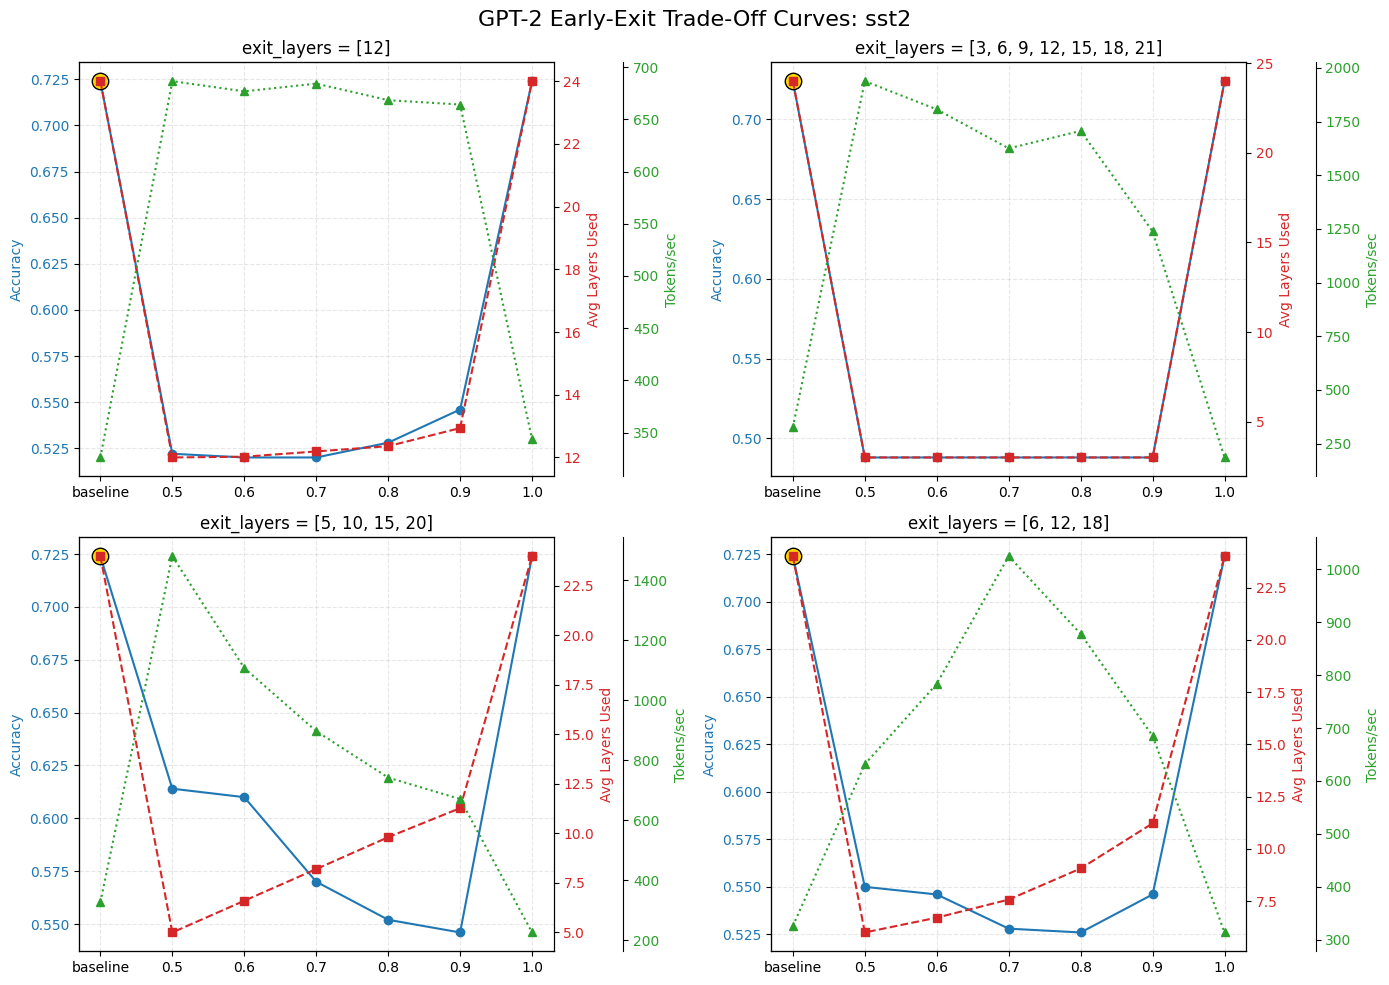

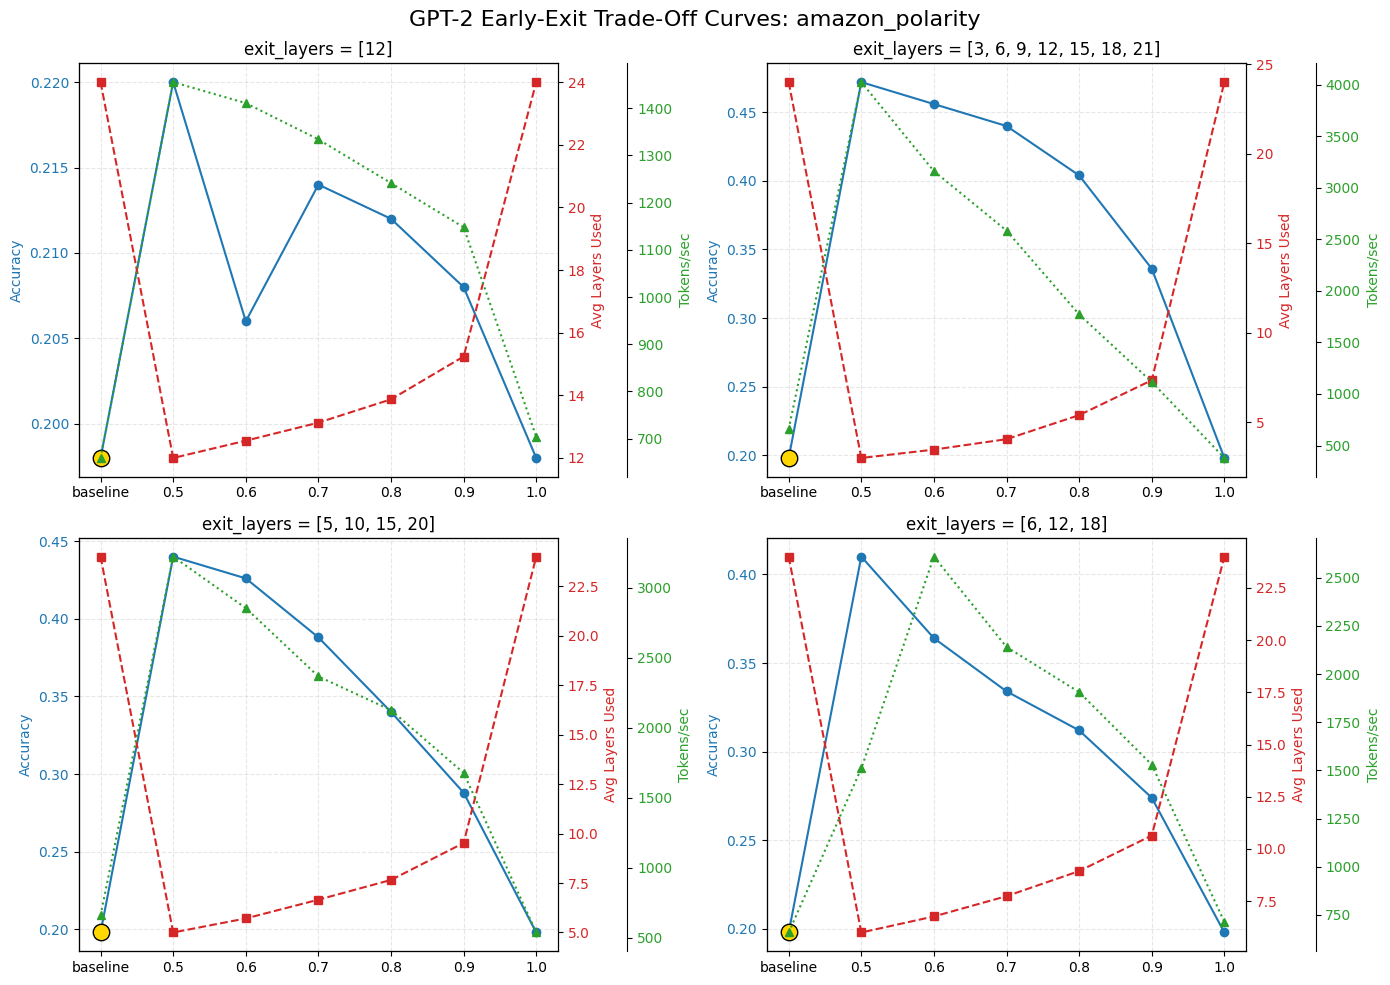

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

df2 = df.copy()

# Replace NaN thresholds with 'baseline'
df2['threshold'] = df2['threshold'].apply(
    lambda x: "baseline" if pd.isna(x) else x
)

# Convert exit_layers list → string for grouping
df2['exit_layers_str'] = df2['exit_layers'].apply(lambda x: str(x))

datasets = df2['dataset'].unique()

for ds in datasets:

    df_ds = df2[df2['dataset'] == ds]

    # Get all exit_layers configs EXCEPT baseline
    exit_configs = sorted(df_ds['exit_layers_str'].unique())
    exit_configs = [cfg for cfg in exit_configs if cfg != "nan"]

    # Only keep configs that are real lists (not baseline)
    # ensure exactly 4 for plotting (or fewer → still works)
    exit_configs = exit_configs[:4]

    # Prepare 2×2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # Extract baseline row(s)
    df_base = df_ds[df_ds['mode'] == "baseline"]

    # ---------- LOOP OVER EXIT CONFIGS ----------
    for idx, exit_cfg in enumerate(exit_configs):

        ax = axes[idx]

        # Subset for this exit layers
        df_sub = df_ds[df_ds['exit_layers_str'] == exit_cfg]

        ###########################################
        # 1) Extract values (early-exit run)
        ###########################################
        # Early exit values
        thresholds = df_sub['threshold'].tolist()
        scores     = df_sub['score'].tolist()
        layers     = df_sub['avg_layers_used'].tolist()
        tps        = df_sub['tokens_per_sec'].tolist()
        
        # Add baseline explicitly (first element)
        if not df_base.empty:
            thresholds = ["baseline"] + thresholds
            scores     = [df_base['score'].iloc[0]] + scores
            layers     = [df_base['avg_layers_used'].iloc[0]] + layers
            tps        = [df_base['tokens_per_sec'].iloc[0]] + tps


        ###########################################
        # 2) Extract baseline values
        ###########################################
        base_thresholds = df_base['threshold'].tolist()
        base_scores     = df_base['score'].tolist()
        base_layers     = df_base['avg_layers_used'].tolist()
        base_tps        = df_base['tokens_per_sec'].tolist()

        # ---- Sorting helper: baseline always first ----
        def sort_key(x):
            return -1 if x == "baseline" else float(x)

        sorted_idx = sorted(
            range(len(thresholds)),
            key=lambda i: sort_key(thresholds[i])
        )

        thresholds = [thresholds[i] for i in sorted_idx]
        scores     = [scores[i]     for i in sorted_idx]
        layers     = [layers[i]     for i in sorted_idx]
        tps        = [tps[i]        for i in sorted_idx]

        x_pos = np.arange(len(thresholds))

        ################################################
        # ---- PLOTS (same style as your original) ----
        ################################################
        ax1 = ax

        # Accuracy curve
        ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
        ax1.set_ylabel("Accuracy", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")

        # Plot baseline point in gold
        for i, th in enumerate(thresholds):
            if th == "baseline":
                ax1.scatter(
                    x_pos[i], scores[i],
                    color="gold", s=140, edgecolor="black", zorder=6,
                    label="Baseline"
                )

        # Avg layers
        ax2 = ax1.twinx()
        ax2.plot(
            x_pos, layers,
            marker="s", linestyle="--",
            color="tab:red", label="Layers Used"
        )
        ax2.set_ylabel("Avg Layers Used", color="tab:red")
        ax2.tick_params(axis="y", labelcolor="tab:red")

        # Tokens/sec
        ax3 = ax1.twinx()
        ax3.spines["right"].set_position(("outward", 50))
        ax3.plot(
            x_pos, tps,
            marker="^", linestyle=":",
            color="tab:green", label="Tokens/sec"
        )
        ax3.set_ylabel("Tokens/sec", color="tab:green")
        ax3.tick_params(axis="y", labelcolor="tab:green")

        ax.set_xticks(x_pos)
        ax.set_xticklabels(thresholds)
        ax.set_title(f"exit_layers = {exit_cfg}")

        ax.grid(True, linestyle="--", alpha=0.3)

    # ------- FIGURE TITLE -------
    fig.suptitle(f"GPT-2 Early-Exit Trade-Off Curves: {ds}", fontsize=16)
    plt.tight_layout()
    plt.show()